<a href="https://colab.research.google.com/github/dD2405/Intro_to_TensorFlow/blob/master/7_Saving_and_Loading_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saving and Loading Models

In this tutorial we will learn how we can take a trained model, save it, and then load it back to keep training it or use it to perform inference. In particular, we will use transfer learning to train a classifier to classify images of cats and dogs, just like we did in the previous lesson. We will then take our trained model and save it as an HDF5 file, which is the format used by Keras. We will then load this model, use it to perform predictions, and then continue to train the model. Finally, we will save our trained model as a TensorFlow SavedModel and then we will download it to a local disk, so that it can later be used for deployment in different platforms.


## Concepts that will be covered in this Colab

1. Saving models in HDF5 format for Keras
2. Saving models in the TensorFlow SavedModel format
3. Loading models
4. Download models to Local Disk

# Imports

In this Colab we will use the TensorFlow 2.0 Beta version. 

In [1]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  !pip install -U "tensorflow-gpu==2.0.0rc0" 

TensorFlow 2.x selected.


In [2]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.7.0)
     |████████████████████████████████| 3.1MB 2.8MB/s 
  Found existing installation: tensorflow-datasets 1.3.2
    Uninstalling tensorflow-datasets-1.3.2:
      Successfully uninstalled tensorflow-datasets-1.3.2


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

# Part 1: Load the Cats vs. Dogs Dataset

In [5]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteSJ8FRH/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


The images in the Dogs vs. Cats dataset are not all the same size. So, we need to reformat all images to the resolution expected by MobileNet (224, 224)

In [0]:
def format_image(image, label):
  # `hub` image modules exepct their data normalized to the [0,1] range.
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

# Part 2: Transfer Learning with TensorFlow Hub

We will now use TensorFlow Hub to do Transfer Learning.

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [0]:
feature_extractor.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [9]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

We now train this model like any other, by first calling `compile` followed by `fit`.

In [10]:
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

EPOCHS = 3
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 29s 50ms/step - loss: 0.0546 - accuracy: 0.9822 - val_loss: 0.0325 - val_accuracy: 0.9897
Epoch 2/3
582/582 [==============================] - 17s 29ms/step - loss: 0.0297 - accuracy: 0.9898 - val_loss: 0.0287 - val_accuracy: 0.9908
Epoch 3/3
582/582 [==============================] - 17s 29ms/step - loss: 0.0248 - accuracy: 0.9916 - val_loss: 0.0289 - val_accuracy: 0.9914


## Check the predictions

Get the ordered list of class names.

In [11]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run an image batch through the model and convert the indices to class names.

In [12]:
image_batch, label_batch = next(iter(train_batches.take(1)))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

predicted_class_names

array(['cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat',
       'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog',
       'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog',
       'dog', 'dog', 'cat', 'cat', 'cat'], dtype='<U3')

Let's look at the true labels and predicted ones.

In [13]:
print('label IDs:', label_batch)
print('Predicted IDs:',predicted_ids)

label IDs: [0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0]
Predicted IDs: [0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0]


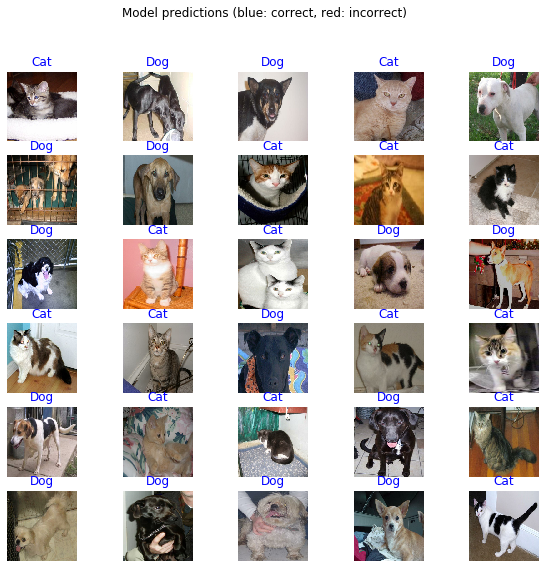

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Part 3: Save as Keras `.h5` model

Now that we've trained the model,  we can save it as an HDF5 file, which is the format used by Keras. Our HDF5 file will have the extension '.h5', and it's name will correspond to the current time stamp.

In [15]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1580299772.h5


In [16]:
!ls

1580299772.h5  sample_data


 You can later recreate the same model from this file, even if you no longer have access to the code that created the model.

This file includes:

- The model's architecture
- The model's weight values (which were learned during training)
- The model's training config (what you passed to `compile`), if any
- The optimizer and its state, if any (this enables you to restart training where you left off)

# Part 4:  Load the Keras `.h5` Model

We will now load the model we just saved into a new model called `reloaded`. We will need to provide the file path and the `custom_objects` parameter. This parameter tells keras how to load the `hub.KerasLayer` from the `feature_extractor` we used for transfer learning.

In [17]:
reloaded = tf.keras.models.load_model(
    export_path_keras, custom_objects={'KerasLayer':hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


We can check that the reloaded model and the previous model give the same result

In [0]:
result_batch = model.predict(image_batch)

reloaded_result_batch = reloaded.predict(image_batch)

In [19]:
result_batch

array([[9.9999964e-01, 3.3631824e-07],
       [6.8648107e-04, 9.9931347e-01],
       [4.4860570e-03, 9.9551398e-01],
       [9.9999988e-01, 9.3021285e-08],
       [2.8161605e-06, 9.9999714e-01],
       [9.5235230e-04, 9.9904758e-01],
       [8.3489617e-04, 9.9916518e-01],
       [9.9999964e-01, 2.9826080e-07],
       [9.9997437e-01, 2.5597079e-05],
       [9.9982530e-01, 1.7478301e-04],
       [5.1474781e-04, 9.9948525e-01],
       [9.9998176e-01, 1.8263596e-05],
       [9.9999964e-01, 4.1685823e-07],
       [3.4242854e-04, 9.9965763e-01],
       [1.1191758e-02, 9.8880821e-01],
       [9.9996471e-01, 3.5299992e-05],
       [9.9993062e-01, 6.9399372e-05],
       [2.4184998e-04, 9.9975818e-01],
       [9.9999690e-01, 3.1399638e-06],
       [9.9999809e-01, 1.8488639e-06],
       [4.9474847e-04, 9.9950528e-01],
       [9.9969244e-01, 3.0757996e-04],
       [9.9987495e-01, 1.2499878e-04],
       [1.3324965e-03, 9.9866748e-01],
       [9.9999762e-01, 2.3966168e-06],
       [1.7156400e-03, 9.

In [20]:
reloaded_result_batch

array([[9.9999964e-01, 3.3631824e-07],
       [6.8648107e-04, 9.9931347e-01],
       [4.4860570e-03, 9.9551398e-01],
       [9.9999988e-01, 9.3021285e-08],
       [2.8161605e-06, 9.9999714e-01],
       [9.5235230e-04, 9.9904758e-01],
       [8.3489617e-04, 9.9916518e-01],
       [9.9999964e-01, 2.9826080e-07],
       [9.9997437e-01, 2.5597079e-05],
       [9.9982530e-01, 1.7478301e-04],
       [5.1474781e-04, 9.9948525e-01],
       [9.9998176e-01, 1.8263596e-05],
       [9.9999964e-01, 4.1685823e-07],
       [3.4242854e-04, 9.9965763e-01],
       [1.1191758e-02, 9.8880821e-01],
       [9.9996471e-01, 3.5299992e-05],
       [9.9993062e-01, 6.9399372e-05],
       [2.4184998e-04, 9.9975818e-01],
       [9.9999690e-01, 3.1399638e-06],
       [9.9999809e-01, 1.8488639e-06],
       [4.9474847e-04, 9.9950528e-01],
       [9.9969244e-01, 3.0757996e-04],
       [9.9987495e-01, 1.2499878e-04],
       [1.3324965e-03, 9.9866748e-01],
       [9.9999762e-01, 2.3966168e-06],
       [1.7156400e-03, 9.

The difference in output should be zero:

In [21]:
(abs(result_batch - reloaded_result_batch)).max()

0.0

As we can see, the result is 0.0, which indicates that both models made the same predictions on the same batch of images.

# Keep Training

Besides making predictions, we can also take our `reloaded` model and keep training it. To do this, you can just train the `reloaded` as usual, using the `.fit` method.

In [22]:
EPOCHS = 3
history = reloaded.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 19s 33ms/step - loss: 0.0219 - accuracy: 0.9924 - val_loss: 0.0402 - val_accuracy: 0.9858
Epoch 2/3
582/582 [==============================] - 17s 29ms/step - loss: 0.0202 - accuracy: 0.9926 - val_loss: 0.0299 - val_accuracy: 0.9901
Epoch 3/3
582/582 [==============================] - 17s 29ms/step - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.0329 - val_accuracy: 0.9908


# Part 5: Export as SavedModel



You can also export a whole model to the TensorFlow SavedModel format. SavedModel is a standalone serialization format for Tensorflow objects, supported by TensorFlow serving as well as TensorFlow implementations other than Python. A SavedModel contains a complete TensorFlow program, including weights and computation. It does not require the original model building code to run, which makes it useful for sharing or deploying (with TFLite, TensorFlow.js, TensorFlow Serving, or TFHub).

The SavedModel files that were created contain:

* A TensorFlow checkpoint containing the model weights.
* A SavedModel proto containing the underlying Tensorflow graph. Separate graphs are saved for prediction (serving), train, and evaluation. If the model wasn't compiled before, then only the inference graph gets exported.
* The model's architecture config, if available.


Let's save our original `model` as a TensorFlow SavedModel. To do this we will use the `tf.saved_model.save()` function. This functions takes in the model we want to save and the path to the folder where we want to save our model. 

This function will create a folder where you will find an `assets` folder, a `variables` folder, and the `saved_model.pb` file. 

In [36]:
t = time.time()

export_path_sm = './{}'.format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1580300777
INFO:tensorflow:Assets written to: ./1580300777/assets


INFO:tensorflow:Assets written to: ./1580300777/assets


In [37]:
!ls {export_path_sm}

assets	saved_model.pb	variables


# Part 6: Load SavedModel

Now, let's load our SavedModel and use it to make predictions. We use the `tf.saved_model.load()` function to load our SavedModels. The object returned by `tf.saved_model.load` is 100% independent of the code that created it.

In [0]:
reloaded_sm = tf.saved_model.load(export_path_sm)

Now, let's use the `reloaded_sm` (reloaded SavedModel) to make predictions on a batch of images.

In [0]:
reloaded_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

In [32]:
reloaded_sm

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f6f5dd8beb8>

In [33]:
reloaded_sm_result_batch

array([[9.9999964e-01, 3.3631824e-07],
       [6.8648107e-04, 9.9931347e-01],
       [4.4860570e-03, 9.9551398e-01],
       [9.9999988e-01, 9.3021285e-08],
       [2.8161605e-06, 9.9999714e-01],
       [9.5235230e-04, 9.9904758e-01],
       [8.3489617e-04, 9.9916518e-01],
       [9.9999964e-01, 2.9826080e-07],
       [9.9997437e-01, 2.5597079e-05],
       [9.9982530e-01, 1.7478301e-04],
       [5.1474781e-04, 9.9948525e-01],
       [9.9998176e-01, 1.8263596e-05],
       [9.9999964e-01, 4.1685823e-07],
       [3.4242854e-04, 9.9965763e-01],
       [1.1191758e-02, 9.8880821e-01],
       [9.9996471e-01, 3.5299992e-05],
       [9.9993062e-01, 6.9399372e-05],
       [2.4184998e-04, 9.9975818e-01],
       [9.9999690e-01, 3.1399638e-06],
       [9.9999809e-01, 1.8488639e-06],
       [4.9474847e-04, 9.9950528e-01],
       [9.9969244e-01, 3.0757996e-04],
       [9.9987495e-01, 1.2499878e-04],
       [1.3324965e-03, 9.9866748e-01],
       [9.9999762e-01, 2.3966168e-06],
       [1.7156400e-03, 9.

We can check that the reloaded SavedModel and the previous model give the same result.

In [35]:
(abs(result_batch - reloaded_sm_result_batch)).max()

0.0

As we can see, the result is 0.0, which indicates that both models made the same predictions on the same batch of images.

# Part 7: Loading the SavedModel as a Keras Model

The object returned by `tf.saved_model.load` is not a Keras object (i.e. doesn't have `.fit`, `.predict`, `.summary`, etc. methods). Therefore, you can't simply take your `reloaded_sm` model and keep training it by running `.fit`. To be able to get back a full keras model from the Tensorflow SavedModel format we must use the `tf.keras.models.load_model` function. This function will work the same as before, except now we pass the path to the folder containing our SavedModel.

In [39]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./1580301523
INFO:tensorflow:Assets written to: ./1580301523/assets


INFO:tensorflow:Assets written to: ./1580301523/assets


In [40]:
reloaded_sm_keras = tf.keras.models.load_model(
    export_path_sm, custom_objects={'KerasLayer': hub.KerasLayer})

reloaded_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Now, let's use the `reloaded_sm)keras` (reloaded Keras model from our SavedModel) to make predictions on a batch of images.

In [0]:
result_batch = model.predict(image_batch)
reloaded_sm_keras_result_batch = reloaded_sm_keras.predict(image_batch)

In [45]:
reloaded_sm_keras_result_batch

array([[9.9999964e-01, 3.3631824e-07],
       [6.8648107e-04, 9.9931347e-01],
       [4.4860570e-03, 9.9551398e-01],
       [9.9999988e-01, 9.3021285e-08],
       [2.8161605e-06, 9.9999714e-01],
       [9.5235230e-04, 9.9904758e-01],
       [8.3489617e-04, 9.9916518e-01],
       [9.9999964e-01, 2.9826080e-07],
       [9.9997437e-01, 2.5597079e-05],
       [9.9982530e-01, 1.7478301e-04],
       [5.1474781e-04, 9.9948525e-01],
       [9.9998176e-01, 1.8263596e-05],
       [9.9999964e-01, 4.1685823e-07],
       [3.4242854e-04, 9.9965763e-01],
       [1.1191758e-02, 9.8880821e-01],
       [9.9996471e-01, 3.5299992e-05],
       [9.9993062e-01, 6.9399372e-05],
       [2.4184998e-04, 9.9975818e-01],
       [9.9999690e-01, 3.1399638e-06],
       [9.9999809e-01, 1.8488639e-06],
       [4.9474847e-04, 9.9950528e-01],
       [9.9969244e-01, 3.0757996e-04],
       [9.9987495e-01, 1.2499878e-04],
       [1.3324965e-03, 9.9866748e-01],
       [9.9999762e-01, 2.3966168e-06],
       [1.7156400e-03, 9.

In [47]:
(abs(result_batch - reloaded_sm_keras_result_batch)).max()

0.0

# Part 8:  Download your model

You can download the SavedModel to your local disk by creating a zip file. We wil use the `-r` (recursice) option to zip all subfolders. 

In [48]:
!zip -r model.zip {export_path_sm}

  adding: 1580301523/ (stored 0%)
  adding: 1580301523/saved_model.pb (deflated 93%)
  adding: 1580301523/assets/ (stored 0%)
  adding: 1580301523/variables/ (stored 0%)
  adding: 1580301523/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: 1580301523/variables/variables.index (deflated 79%)
  adding: 1580301523/variables/variables.data-00000-of-00002 (deflated 88%)


In [49]:
!ls

1580299772.h5  1580299941  1580300777  1580301523  model.zip  sample_data


In [0]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass